In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import seaborn as sns

### Data Loader

In [2]:
trainfile = pd.read_csv('digit-recognizer/train.csv')
# trainimg = [np.reshape(row[1].values,(28,28)) for row in trainfile.drop(columns=['label']).iterrows()]
trainimg = [(row[1].values[0], np.reshape(row[1].values[1:],(28,28))) for row in trainfile.iterrows()]


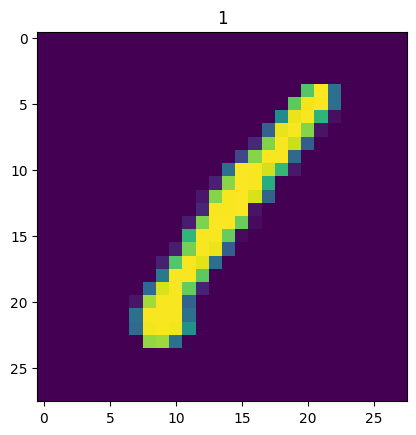

In [3]:
for img in trainimg:
#     print(img[1])
#     break
    plt.title(img[0])
    plt.imshow(img[1])
    break



In [ ]:
class DigitDataset(Dataset):
    def __init__(self, file, img_dir, transform=None, target_transform=None):
        # self.img_labels = pd.read_csv(img_dir)['label']
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_label)
    
    def __getitem__(self,idx):
        # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # image = read_image(img_path)
        # label = self.img_labels.iloc[idx, 1]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        # return image, label